<a id='top-page'></a>
# `pykitPIV` demo: Learn to locate sources/sinks in a 2D PIV experiment using reinforcement learning

In this notebook, we show how the available functionalities from the machine learning module (`pykitPIV.ml`) can be used to train a reinforcement learning (RL) agent to navigate the virtual PIV camera towards sources/sinks in a radial flow.

We use a **single deep Q-learning** agent without memory replay, as implemented in the class `pykitPIV.ml.CameraAgentSingleDQN`. 

Note that other RL algorithms are also possible, such as double deep Q-learning with memory replay (see other camera agent classes implemented in the `pykitPIV.ml` module).

The agent can perform one of the five actions:

- Move up
- Move down
- Move right
- Move left
- Stay

on the virtual camera, thereby with each step it moves the virtual PIV camera in 2D by $N$ pixels.

<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size="3"><strong>Table of contents:</strong></font>
<br>
<ol>
    <li><a href="#initializations">Initializations</a></li>
    <ul>
        <li><a href="#prepare-specs">Prepare specifications for pykitPIV parameters</a></li>
        <li><a href="#prepare-inference">Prepare the CNN-based inference model for PIV images</a></li>
    </ul>
    <li><a href="#create-env">Create the RL environment</a></li>
    <li><a href="#create-agent">Create and train the RL agent</a></li>
    <ul>
        <li><a href="#visualize-training">Visualize the training metrics and the training progress</a></li>
        <li><a href="#visualize-policy">Visualize the learned policy in the training environment</a></li>
    </ul>
    <li><a href="#test-agent">Test the trained agent in a new environment</a></li>
    <ul>
        <li><a href="#visualize-test">Visualize the learned policy in the test environment</a></li>
        <li><a href="#visualize-trajectory">Visualize one sample trajectory in the test environment</a></li>
    </ul>
    <li><a href="#upload-network">Upload the trained Q-network</a></li>
</ol>
<p></p>
</div>
<br>

***

In [1]:
from pykitPIV.ml import PIVEnv, CameraAgentSingleDQN, Rewards, Cues, plot_trajectory
from pykitPIV.flowfield import compute_q_criterion, compute_divergence
from pykitPIV import ParticleSpecs, FlowFieldSpecs, MotionSpecs, ImageSpecs
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import cmcrameri.cm as cmc
import numpy as np
import onnxruntime
import tensorflow as tf
import pandas as pd
import h5py
import torch
import sys, os
import time
import copy as cp

2025-05-08 16:26:13.253678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
save_images = False
filename = None

In [3]:
action_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap_actions = ListedColormap(action_colors)

In [4]:
interrogation_window_size = (40,40)
interrogation_window_size_buffer = 3

<a class="anchor" id='initializations'></a>
***

## Initializations

[Go to the top](#top-page)

<a id='prepare-specs'></a>

### Prepare specifications for pykitPIV parameters

[Go to the top](#top-page)

In [5]:
particle_spec = ParticleSpecs(diameters=(1, 1),
                              distances=(2, 2),
                              densities=(0.4, 0.4),
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=(1, 1),
distances=(2, 2),
densities=(0.4, 0.4),
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [6]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [7]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [8]:
image_spec = ImageSpecs(exposures=(0.98, 0.98),
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=(0.98, 0.98),
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


<a id='prepare-inference'></a>

### Prepare the CNN-based inference model for PIV images

[Go to the top](#top-page)

In [9]:
class ONNXmodel:
    
    def __init__(self,
                 onnx_file_path):
        
        self.name = "ONNX"
        self.providers = ['CPUExecutionProvider']
        self.session = onnxruntime.InferenceSession(onnx_file_path, 
                                                    None,
                                                    providers=self.providers)

        self.input_name = self.session.get_inputs()[0].name  
        print('Input Name:', self.input_name)   
 
    def inference(self, x):
        
        output = self.session.run([], {self.input_name:x/np.max(x)})[0] 
      
        return output

    def empty(self):
        
         with torch.no_grad():
            torch.cuda.empty_cache()

In [10]:
model_file = '../Lima_L4_PAD_SR2_dyn.onnx'
print("model:", model_file, '  exist:', os.path.exists(model_file))

model: ../Lima_L4_PAD_SR2_dyn.onnx   exist: True


In [11]:
lima_inference_model = ONNXmodel(model_file)

Input Name: Input


<a id=create-env></a>

***

## Create the RL environment

[Go to the top](#top-page)

Define the sensory cues that the RL agent effectively senses and learns from:

In [12]:
cues_obj = Cues(sample_every_n=10, 
                normalize_displacement_vectors=False)

cues_function = cues_obj.sampled_vectors

Initialize the `Gymnasium`-based virtual wind tunnel environment using the `PIVEnv` class:

In [13]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=interrogation_window_size_buffer,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             user_flowfield=None,
             inference_model=None,
             random_seed=None)

In [14]:
camera_position, cues = env.reset(imposed_camera_position=np.array([40, 20]), regenerate_flowfield=True)

Inspect how many sensory cues this agent will see (these become the inputs to the single deep Q-network):

In [15]:
cues.shape

(1, 32)

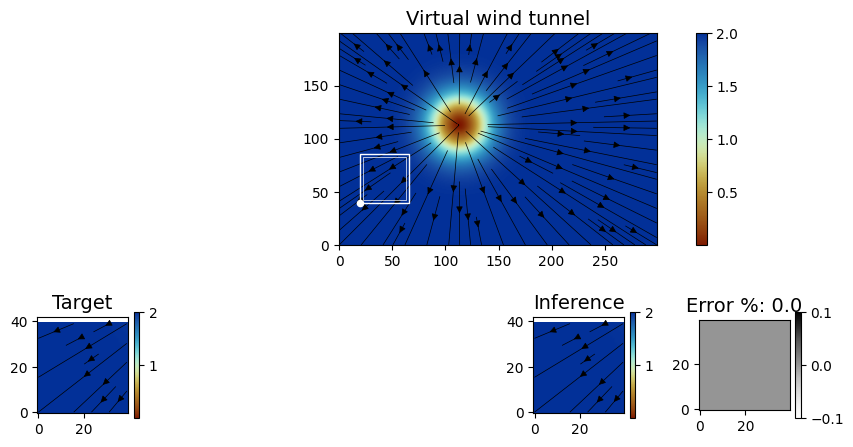

In [16]:
if save_images: filename = 'ml_PIVEnv_render.png'
plt = env.render(quantity=None,
                 camera_position=camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma,
                 add_streamplot=True,
                 streamplot_density=1,
                 streamplot_color='k',
                 streamplot_linewidth=0.5,
                 figsize=(10,5), 
                 filename=filename)

<a id=create-agent></a>

***

## Create and train the RL agent

[Go to the top](#top-page)

We will train the RL agent on 1000 episodes, where at the beginning of each new episose, a new radial field is generated:

In [19]:
n_episodes = 3000

The number of episodes for logging information about training:

In [20]:
log_every = 200

We will let the RL agent take 20 steps (camera movements) per episode:

In [21]:
n_iterations = 20

Each step will be magnified 10 times, i.e., instead of the step being a movement of camera by 1px, it will be a movement by 10px:

In [22]:
magnify_step = 10

Define the discount factor for the future rewards, $\gamma$:

In [23]:
discount_factor = 0.95

Specify the parameters for the $\varepsilon$-greedy policy:

In [24]:
epsilon_start = 0.5
epsilon_end = 0.0
n_episodes_epsilon_decay = int(4/5 * n_episodes)

Specify the parameters for the learning rate decay:

In [25]:
initial_learning_rate = 0.001
alpha_lr = 0.01
n_episodes_learning_rate_decay = int(4/5 * n_episodes)

Specify the kernel initializer for the weights in the Q-network:

In [26]:
kernel_initializer = tf.keras.initializers.RandomUniform

Specify the gradient descent optimizer to use, it can be `'RMSprop'` or `'Adam'`:

In [27]:
optimizer = 'Adam'

Define the exploration probability decay:

In [28]:
def epsilon_decay(episode, 
                  epsilon_start,
                  epsilon_end,
                  n_decay_steps):
    
    if episode < n_decay_steps:
        return epsilon_start - (episode / n_decay_steps) * (epsilon_start - epsilon_end)
    else:
        return epsilon_end

In [29]:
exploration_probabilities = []

for i in range(0,n_episodes):

    exploration_probabilities.append(epsilon_decay(i, epsilon_start, epsilon_end, n_decay_steps=n_episodes_epsilon_decay))

Inspect how the exploration probability will be decayed over the episodes:

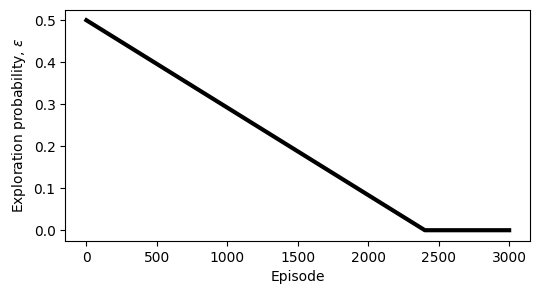

In [30]:
plt.figure(figsize=(6,3))
plt.plot(exploration_probabilities, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Exploration probability, $\varepsilon$');

Define the cosine learning rate decay:

In [31]:
def learning_rate_decay(episode, 
                        initial_learning_rate, 
                        alpha_lr, 
                        n_decay_steps):
    
    episode = np.min([episode, n_decay_steps])
    cosine_decay = 0.5 * (1 + np.cos(np.pi * episode / n_decay_steps))
    decayed = (1 - alpha_lr) * cosine_decay + alpha_lr
    
    return initial_learning_rate * decayed

In [32]:
decayed_learning_rates = []

for i in range(0,n_episodes):

    decayed_learning_rates.append(learning_rate_decay(i,
                                                      initial_learning_rate=initial_learning_rate, 
                                                      alpha_lr=alpha_lr, 
                                                      n_decay_steps=n_episodes_learning_rate_decay))

Inspect how the learning rate will be decayed over the episodes:

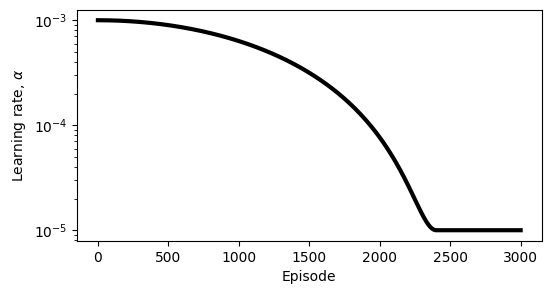

In [33]:
plt.figure(figsize=(6,3))
plt.semilogy(decayed_learning_rates, c='k', lw=3)
plt.xlabel('Episode')
plt.ylabel(r'Learning rate, $\alpha$');

We define the architecture for the deep Q-network:

In [34]:
size_of_hidden_unit = int(env.n_cues/2)
size_of_hidden_unit

16

In [35]:
class QNetwork(tf.keras.Model):

    def __init__(self, n_actions, kernel_initializer):

        super(QNetwork, self).__init__()

        self.dense1 = tf.keras.layers.Dense(env.n_cues, activation='relu', kernel_initializer=kernel_initializer)
        self.dense2 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.dense3 = tf.keras.layers.Dense(size_of_hidden_unit, activation='relu', kernel_initializer=kernel_initializer)
        self.output_layer = tf.keras.layers.Dense(n_actions, activation='relu', kernel_initializer=kernel_initializer)

    def call(self, state):

        x = self.dense1(state)
        x = self.dense2(x)
        x = self.dense3(x)

        return self.output_layer(x)

Initialize the camera agent using the `CameraAgentSingleDQN` class:

In [36]:
ca = CameraAgentSingleDQN(env=env,
                          q_network=QNetwork(env.n_actions, kernel_initializer),
                          learning_rate=initial_learning_rate,
                          optimizer=optimizer,
                          discount_factor=discount_factor)

The uploaded environment has 5 actions.


We are going to use the reward based on divergence:

In [37]:
rewards = Rewards(verbose=False)
reward_function = rewards.divergence

Define a transformation function for the reward which is appropriate to detecting regions of high divergence:

In [38]:
def reward_transformation(div):  
    return np.max(np.abs(div))

Run training of the RL agent. Note that we are regenerating the radial flowfield at the beginning of each episode to present as many unseen scenarios during training as possible. This should help in training and generalization.

In [39]:
total_tic = time.perf_counter()

print()
print('- '*20)
print('Starting training the RL agent...\n')

tic = time.perf_counter()

iter_count = 0

collected_rewards = []
collected_average_rewards = []
collected_logged_episodes = []

current_lr = cp.deepcopy(initial_learning_rate)

batch_q_values_collected = np.zeros((1, env.n_actions))

average_reward = 0.0

for episode in range(0, n_episodes):

    camera_position, cues = ca.env.reset(regenerate_flowfield=True)
    
    total_reward = 0.0

    # Exploration probability decreases with training time:
    epsilon = epsilon_decay(episode=iter_count, 
                            epsilon_start=epsilon_start,
                            epsilon_end=epsilon_end,
                            n_decay_steps=n_episodes_epsilon_decay)

    # Decay the learning rate:
    current_lr = learning_rate_decay(episode=iter_count, 
                                     initial_learning_rate=initial_learning_rate, 
                                     alpha_lr=alpha_lr, 
                                     n_decay_steps=n_episodes_learning_rate_decay)
    
    iter_count += 1

    if (episode) % log_every == 0:

        print(f'Episode: {episode + 1}')
        print(f'Epsilon: {epsilon:0.3f}')
        print('Learning rate: ' + str(current_lr))

    # In each episode, take a number of iterations in the environment:
    for i in range(0,n_iterations):

        # Select an action:
        action = ca.choose_action(cues,
                                  epsilon=epsilon)

        next_camera_position, next_cues, reward = ca.env.step(action,
                                                              reward_function=reward_function,
                                                              reward_transformation=reward_transformation,
                                                              magnify_step=magnify_step,
                                                              verbose=False)


        total_reward += reward
        average_reward += reward

        # Train the RL agent with the current step:
        ca.train(cues=cues,
                 action=action,
                 reward=reward,
                 next_cues=next_cues,
                 new_learning_rate=current_lr)

        cues = next_cues
    
    batch_q_values = ca.q_network(cues, training=False).numpy()
    batch_q_values_collected = np.vstack((batch_q_values_collected, batch_q_values))

    if (episode) % log_every == 0:

        toc = time.perf_counter()

        collected_average_rewards.append(average_reward/log_every)
        collected_logged_episodes.append(episode)

        print(f"Average reward: {(average_reward/log_every):0.1f}")
        print(f'These episodes took: {(toc - tic):0.1f} sec.')
        print('- '*15)
        print()

        average_reward = 0.0

        tic = time.perf_counter()

    collected_rewards.append(total_reward)

batch_q_values_collected = batch_q_values_collected[1::,:]

total_toc = time.perf_counter()
print()
print('- '*20)
print(f'Total training time: {(total_toc - total_tic)/60:0.1f} minutes.')


- - - - - - - - - - - - - - - - - - - - 
Starting training the RL agent...

Episode: 1
Epsilon: 0.500
Learning rate: 0.001
Average reward: 0.0
These episodes took: 0.9 sec.
- - - - - - - - - - - - - - - 

Episode: 201
Epsilon: 0.458
Learning rate: 0.0009831332840130888
Average reward: 0.7
These episodes took: 177.6 sec.
- - - - - - - - - - - - - - - 

Episode: 401
Epsilon: 0.417
Learning rate: 0.0009336825748732971
Average reward: 0.9
These episodes took: 170.8 sec.
- - - - - - - - - - - - - - - 

Episode: 601
Epsilon: 0.375
Learning rate: 0.000855017856687341
Average reward: 0.9
These episodes took: 147.0 sec.
- - - - - - - - - - - - - - - 

Episode: 801
Epsilon: 0.333
Learning rate: 0.0007524999999999999
Average reward: 0.8
These episodes took: 144.9 sec.
- - - - - - - - - - - - - - - 

Episode: 1001
Epsilon: 0.292
Learning rate: 0.0006331154273257479
Average reward: 0.9
These episodes took: 143.4 sec.
- - - - - - - - - - - - - - - 

Episode: 1201
Epsilon: 0.250
Learning rate: 0.000

You can view the current weights and biases:

In [43]:
WB = ca.view_weights()

You can also save the current trained deep Q-network. Go to the end of this Jupyter notebook to learn how to upload the trained deep Q-network in the future.

In [44]:
ca.q_network.save('SingleDQN.keras')

### Visualize the training metrics and the training progress

(0.0, 3000.0)

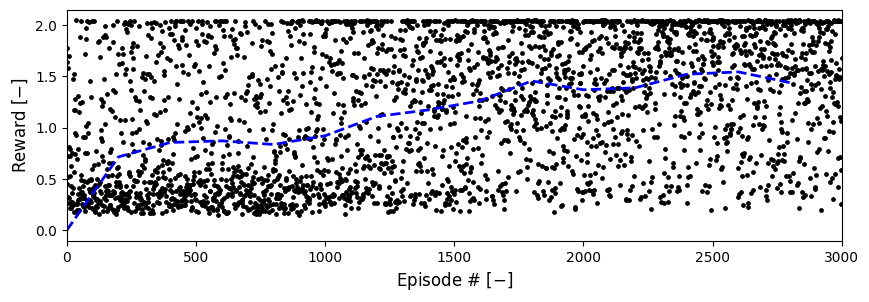

In [40]:
plt.figure(figsize=(10,3))
plt.scatter([i for i in range(0, len(collected_rewards))], collected_rewards, s=6, c='k')
plt.plot(collected_logged_episodes, collected_average_rewards, '--', c='b', lw=2)
plt.ylabel('Reward [$-$]', fontsize=12)
plt.xlabel('Episode # [$-$]', fontsize=12)
plt.xlim([0, n_episodes])

Text(0.5, 0, 'Episode # [$-$]')

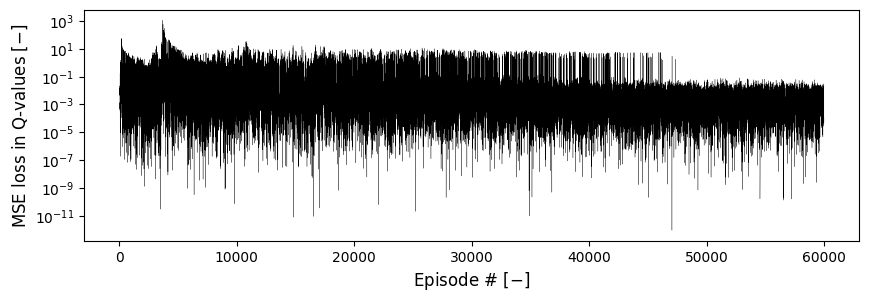

In [41]:
MSE_losses_collected = np.array(ca.MSE_losses).ravel()
plt.figure(figsize=(10,3))
plt.semilogy(MSE_losses_collected, color='k', lw=0.2)
plt.ylabel('MSE loss in Q-values [$-$]', fontsize=12)
plt.xlabel('Episode # [$-$]', fontsize=12)

Text(0, 0.5, 'Q-value')

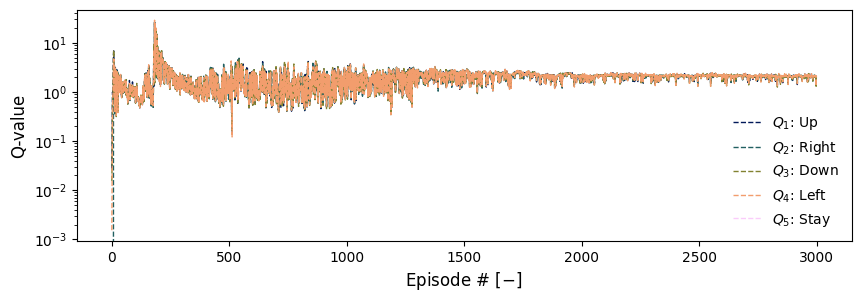

In [42]:
plt.figure(figsize=(10,3))
for i in range(0,env.n_actions):
    plt.semilogy(batch_q_values_collected[:,i], '--', label='$Q_' + str(i+1) + '$: ' + env.action_to_verbose_direction[i], color=action_colors[i], lw=1)
plt.legend(frameon=False)
plt.xlabel('Episode # [$-$]', fontsize=12)
plt.ylabel('Q-value', fontsize=12)

### Visualize the learned policy in the training environment

Create sparse samples of camera position on a uniform grid:

In [45]:
(_, _, H, W) = ca.env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = ca.env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 2 == 0]
idx_W = [i for i in range(0, W_adm) if i % 2 == 0]
print(len(idx_H) * len(idx_W))

9779


In [46]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = ca.env.reset(imposed_camera_position=camera_position)
        q_values = ca.q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 32.1 sec.


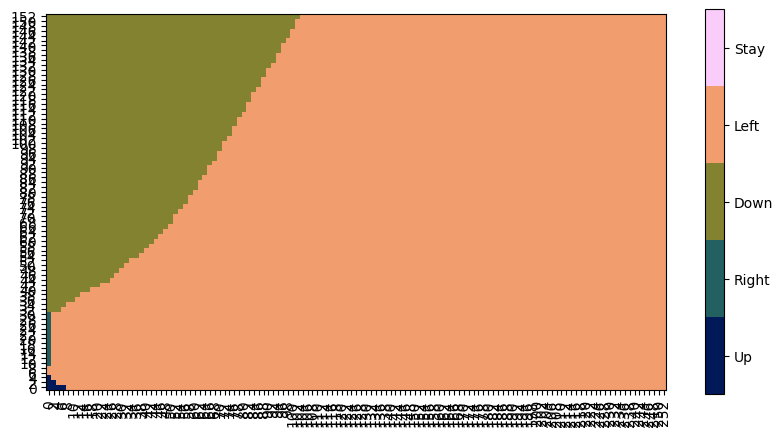

In [47]:
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(10,5))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(ca.env.action_to_verbose_direction.values()))
plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
plt.yticks([i for i in range(0,len(idx_H))], idx_H);
plt.savefig('policy.png', dpi=300, bbox_inches='tight')

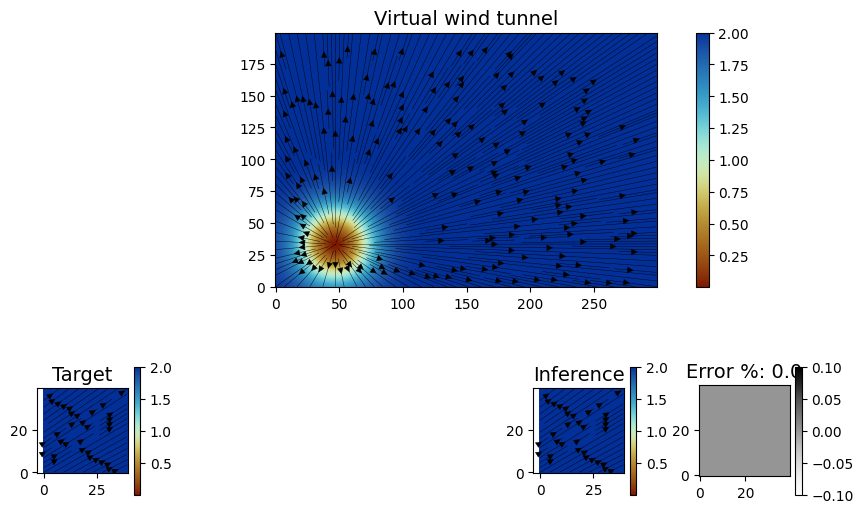

In [48]:
if save_images: filename = 'final-environment.png'
plt = ca.env.render(quantity=None,
                    camera_position=None,
                    c='white',
                    s=20,
                    lw=1,
                    normalize_cbars=True,
                    cmap=cmc.roma,
                    add_streamplot=True,
                    streamplot_density=3,
                    streamplot_color='k',
                    streamplot_linewidth=0.3,
                    figsize=(10,6), 
                    filename=filename);

***

## Test the trained agent in a new environment

In [49]:
particle_spec = ParticleSpecs(diameters=1,
                              distances=2,
                              densities=0.4,
                              diameter_std=0,
                              seeding_mode='random')

print(particle_spec)

ParticleSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
diameters=1,
distances=2,
densities=0.4,
diameter_std=0,
seeding_mode='random',
random_seed=None)


In [50]:
flowfield_spec = FlowFieldSpecs(size=(200,300),
                                flowfield_type='radial',
                                radial_epsilon=1e-6,
                                radial_source=True,
                                radial_sigma=20,
                                radial_imposed_source_location=None,
                                displacement=(2, 2))

print(flowfield_spec)

FlowFieldSpecs(n_images=1,
size=(200, 300),
size_buffer=10,
random_seed=None,
flowfield_type='radial',
gaussian_filters=(10, 10),
n_gaussian_filter_iter=10,
displacement=(2, 2),
radial_source=True,
radial_imposed_source_location=None,
radial_sigma=20,
radial_epsilon=1e-06,
apply_SLM=False,
integral_time_scale=1,
sigma=1,
n_stochastic_particles=1000000,
n_iterations=100)


In [51]:
motion_spec = MotionSpecs(n_steps=10,
                          time_separation=1,
                          particle_loss=(0, 0),
                          particle_gain=(0, 0))

print(motion_spec)

MotionSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
n_steps=10,
time_separation=1,
particle_loss=(0, 0),
particle_gain=(0, 0),
random_seed=None)


In [52]:
image_spec = ImageSpecs(exposures=0.98,
                        maximum_intensity=2**16-1,
                        laser_beam_thickness=1,
                        laser_over_exposure=1,
                        laser_beam_shape=0.95,
                        alpha=1/8,
                        clip_intensities=True,
                        normalize_intensities=False)

print(image_spec)

ImageSpecs(n_images=1,
size=(512, 512),
size_buffer=10,
random_seed=None,
exposures=0.98,
maximum_intensity=65535,
laser_beam_thickness=1,
laser_over_exposure=1,
laser_beam_shape=0.95,
no_laser_plane=False,
alpha=0.125,
extend_gaussian=1,
covariance_matrix=None,
clip_intensities=True,
normalize_intensities=False)


In [53]:
test_env = PIVEnv(interrogation_window_size=interrogation_window_size,
                  interrogation_window_size_buffer=interrogation_window_size_buffer,
                  cues_function=cues_function,
                  particle_spec=particle_spec,
                  motion_spec=motion_spec,
                  image_spec=image_spec,
                  flowfield_spec=flowfield_spec,
                  user_flowfield=None,
                  inference_model=None,
                  random_seed=None)

In [66]:
interrogation_window_size_buffer

3

In [54]:
camera_position, cues = test_env.reset()

In [55]:
camera_position

array([ 53, 170])

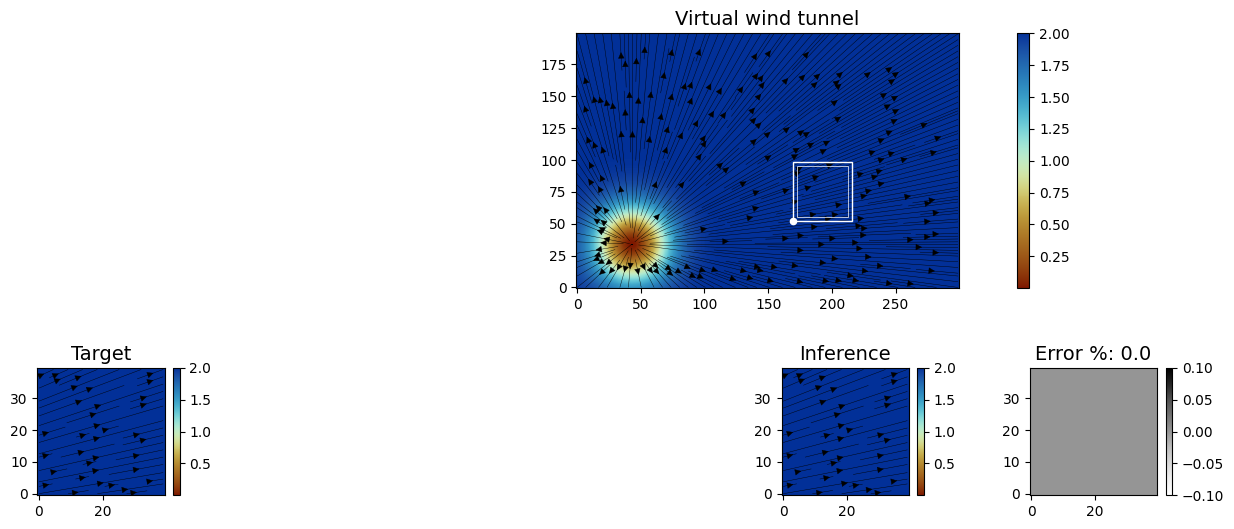

In [56]:
plt = test_env.render(quantity=None,
                      camera_position=camera_position,
                      c='white',
                      s=20,
                      lw=1,
                      normalize_cbars=True,
                      cmap=cmc.roma,
                      add_streamplot=True,
                      streamplot_density=3,
                      streamplot_color='k',
                      streamplot_linewidth=0.3,
                      figsize=(15,6), 
                      filename=None);

### Visualize the learned policy in the test environment

Create sparse samples of camera position on a uniform grid:

In [57]:
(_, _, H, W) = test_env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = test_env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 2 == 0]
idx_W = [i for i in range(0, W_adm) if i % 2 == 0]
print(len(idx_H) * len(idx_W))

39116


In [58]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = test_env.reset(imposed_camera_position=camera_position)
        q_values = ca.q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

	Time it took: 146.7 sec.


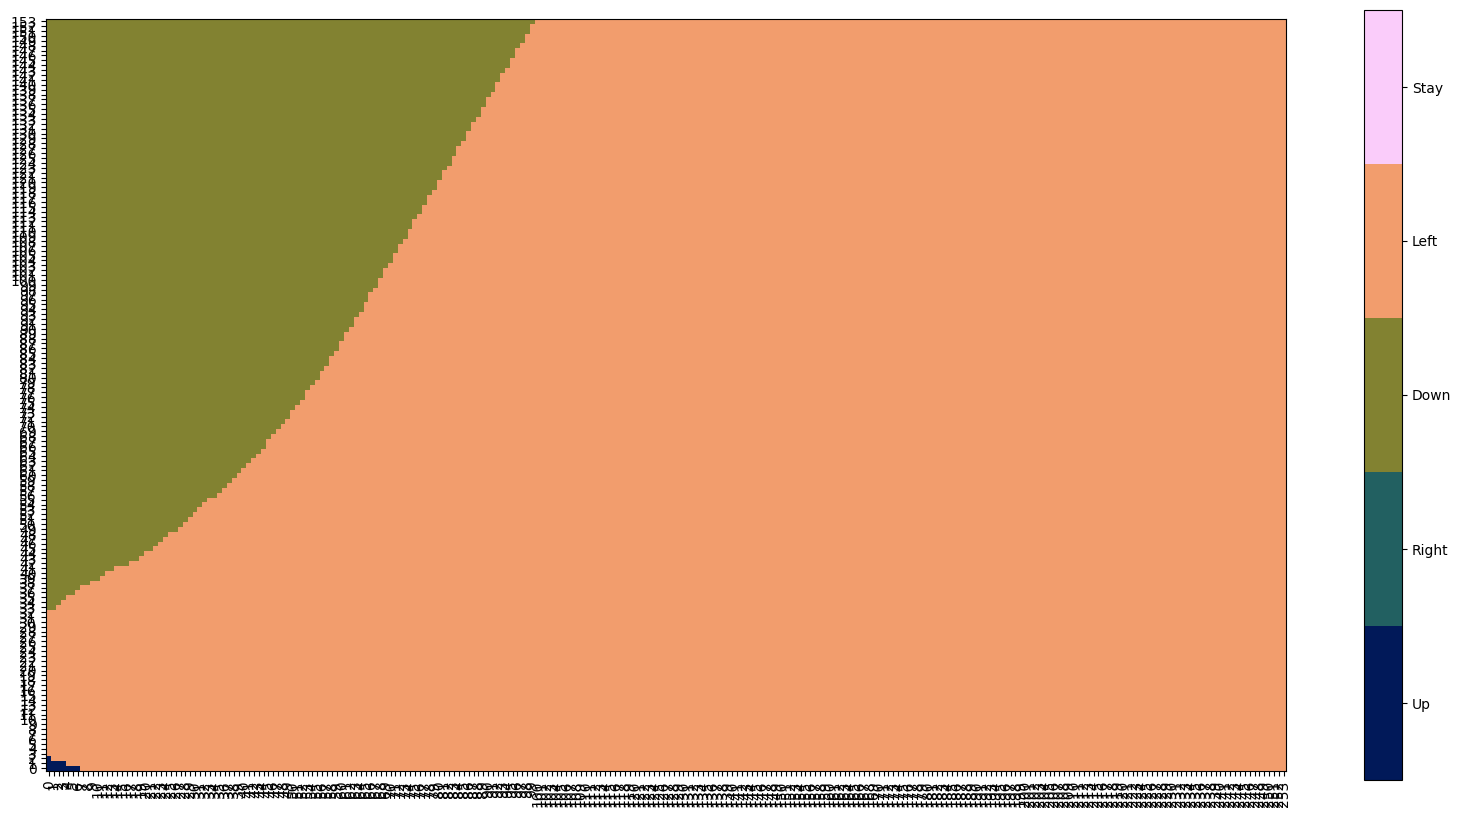

In [59]:
from matplotlib.colors import ListedColormap
cluster_colors = cmc.batlow(np.linspace(0, 1, 5))
cmap = ListedColormap(cluster_colors)

plt.figure(figsize=(20,10))
plt.imshow(learned_policy, origin='lower', cmap=cmap, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(test_env.action_to_verbose_direction.values()))
plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
plt.yticks([i for i in range(0,len(idx_H))], idx_H);
# plt.xlim([90,110])
# plt.ylim([0,20])
plt.savefig('tested-policy.png', dpi=300, bbox_inches='tight')

### Visualize one sample trajectory in the test environment

We are going to take a number of steps in the environment:

In [60]:
n_steps = 100

In [61]:
saved_camera_trajectories = np.zeros((n_steps,2))

In [62]:
camera_position, cues = test_env.reset(imposed_camera_position=(60,100))

In [63]:
for i in range(0,n_steps):

    saved_camera_trajectories[i, 0] = camera_position[0]
    saved_camera_trajectories[i, 1] = camera_position[1]

    q_values = ca.q_network(cues)

    action = np.argmax(q_values)

    print(test_env.action_to_verbose_direction[action])

    camera_position, cues, reward = test_env.step(action=action,
                                                  reward_function=reward_function,
                                                  reward_transformation=reward_transformation,
                                                  magnify_step=10,
                                                  verbose=False)

Left
Left
Left
Left
Left
Left
Left
Down
Left
Down
Left
Down
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left


In [65]:
interrogation_window_size

(40, 40)

In [ ]:
test_env

TypeError: unsupported operand type(s) for *: 'int' and 'NoneType'

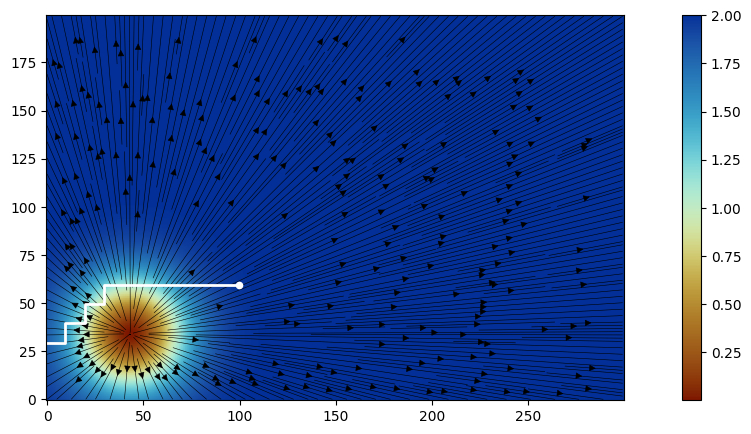

In [64]:
plot_trajectory(test_env.flowfield.velocity_field,
                saved_camera_trajectories,
                interrogation_window_size=interrogation_window_size,
                c_path='white',
                c_init='white',
                c_final='black',
                s=20,
                lw=2,
                xlabel=None,
                ylabel=None,
                xticks=True,
                yticks=True,
                cmap=cmc.roma,
                add_streamplot=True,
                streamplot_density=4,
                streamplot_color='k',
                streamplot_linewidth=0.4,
                figsize=(15,5),
                dpi=300,
                filename=None);

***

## Upload the trained Q-network

Upload the displacement field:

In [ ]:
# path = '/Users/kamilazdybal/GitLab-Empa/pykitPIV/CHPC/RUN-TEST/TEST-'
# path = '/Users/kamilazdybal/GitLab-Empa/pykitPIV/scripts/TEST-'
path = '/Users/kamilazdybal/Desktop/RUN-first-successful-non-normalized-d/large-lr-'

velocity_u = pd.read_csv(path + 'final-velocity-field-u.csv', sep = ',', header=None).to_numpy()
velocity_v = pd.read_csv(path + 'final-velocity-field-v.csv', sep = ',', header=None).to_numpy()

user_velocity = np.zeros((1,2,200,300))
user_velocity[0,0,:,:] = velocity_u
user_velocity[0,1,:,:] = velocity_v

In [ ]:
from pykitPIV import FlowField

user_flowfield = FlowField(n_images=1,
                      size=(200, 300),
                      size_buffer=0,
                      random_seed=100)

user_flowfield.upload_velocity_field(user_velocity)

In [ ]:
flowfield_spec = FlowFieldSpecs(size=(100, 100),
                                flowfield_type='random smooth',
                                gaussian_filters=(10, 10),
                                n_gaussian_filter_iter=10,
                                displacement=(2, 2))

print(flowfield_spec)

In [ ]:
env = PIVEnv(interrogation_window_size=interrogation_window_size,
             interrogation_window_size_buffer=0,
             cues_function=cues_function,
             particle_spec=particle_spec,
             motion_spec=motion_spec,
             image_spec=image_spec,
             flowfield_spec=flowfield_spec,
             inference_model=None,
             user_flowfield=None,
             random_seed=None)

In [ ]:
camera_position, cues = env.reset()

In [ ]:
cues.shape

In [ ]:
plt = env.render(camera_position,
                 c='white',
                 s=20,
                 lw=1,
                 normalize_cbars=True,
                 cmap=cmc.roma_r,
                 add_streamplot=True,
                 streamplot_density=3,
                 streamplot_color='k',
                 streamplot_linewidth=0.3,
                 figsize=(10,6), 
                 filename='final-environment.png')

In [ ]:
trained_q_network = QNetwork(n_actions=env.n_actions, kernel_initializer = tf.keras.initializers.RandomUniform)
_ = trained_q_network(tf.ones((1, env.n_cues)))

In [ ]:
# trained_q_network.load_weights('QNetwork.keras')

In [ ]:
trained_q_network.load_weights(path + 'QNetwork.keras')

Make inference:

In [ ]:
(_, _, H, W) = env.flowfield.velocity_field_magnitude.shape
(H_adm, W_adm) = env.admissible_observation_space
idx_H = [i for i in range(0, H_adm) if i % 1 == 0]
idx_W = [i for i in range(0, W_adm) if i % 1 == 0]
print(len(idx_H) * len(idx_W))

In [ ]:
tic = time.perf_counter()

learned_policy = np.ones((H,W)) * np.nan

for h in idx_H:
    for w in idx_W:

        camera_position = np.array([h, w])
        _, cues = env.reset(imposed_camera_position=camera_position)
        q_values = trained_q_network(cues)
        action = np.argmax(q_values)
        learned_policy[h, w] = action

learned_policy = learned_policy[~np.isnan(learned_policy)]
learned_policy = learned_policy.reshape(len(idx_H), len(idx_W))

toc = time.perf_counter()
print(f'\tTime it took: {(toc - tic):0.1f} sec.')

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(learned_policy, origin='lower', cmap=cmap_actions, vmin=0, vmax=4)
cbar = plt.colorbar()
cbar.set_ticks([4/5*(i+0.5) for i in range(0,5)])
cbar.set_ticklabels(list(env.action_to_verbose_direction.values()))
# plt.xticks([i for i in range(0,len(idx_W))], idx_W, rotation=90)
# plt.yticks([i for i in range(0,len(idx_H))], idx_H);

***